In [1]:
import warnings
warnings.filterwarnings('ignore')

In [47]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
np.random.seed(42)
idx = pd.IndexSlice

## Cross-validation in the time-series context
poses the additional challenge that train and validation sets need to respect the temporal order of the data so that we do not inadvertently train the model on data ‘from the future’ to predict the past, introducing lookahead bias. Scikit-learn’s built-in [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) aims to accomplish this, but does not work for this case because we have multiple time series, one for each ticker. We could solve this by manually subsetting the data for the appropriate train and validation periods. Alternatively, we can create a custom time-series splitter compatible with the scikit-learn Kfold interface (see [Resources](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)). Here is an [example](https://github.com/stefan-jansen/machine-learning-for-trading/blob/master/utils.py) that illustrates how to do so for this case. This allows us to specify fixed `train_length` and `test_length` parameters, as well as a lookahead value that defines the forecast horizon and ensures an appropriate gap between the training and validation set.

In [23]:
data = pd.read_hdf('us_stocks.h5', 'model_data')

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1365787 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZMH', Timestamp('2015-06-25 00:00:00'))
Data columns (total 37 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   ret_01       1365287 non-null  float64
 1   ret_03       1364287 non-null  float64
 2   ret_05       1363287 non-null  float64
 3   ret_10       1360787 non-null  float64
 4   ret_21       1355287 non-null  float64
 5   ret_42       1344787 non-null  float64
 6   ret_63       1334287 non-null  float64
 7   ret_126      1302787 non-null  float64
 8   ret_252      1239787 non-null  float64
 9   ret_fwd      1365787 non-null  float64
 10  BB_UP        1356287 non-null  float64
 11  BB_LOW       1356287 non-null  float64
 12  BB_SQUEEZE   1356287 non-null  float64
 13  ADX          1352287 non-null  float64
 14  MACD         1349287 non-null  float64
 15  MACD_SIGNAL  1349287 non-null  float64
 16  MACD_HIST    13492

In [24]:
target = 'ret_fwd'
features = data.columns.drop(target)
categoricals = ['month', 'weekday']

## Custom Time Series Cross-Validation

[source](https://github.com/stefan-jansen/machine-learning-for-trading/blob/master/utils.py)

In [14]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

## Model Selection: Lookback, lookahead and roll-forward periods

We'll use five years of training data to predict the 1-day forward returns for the following three months for all models.

In [25]:
YEAR = 252 # days
MONTH = 21 # days = 252 / 12

train_length = 5 * YEAR
test_length = 3 * MONTH

lookahead = 1

We'll create 16 quarters worth of out-of-sample predictions so we can select the past 4 quarters to select a model for a subsequent quarter with three years total of out-of-sample forecasts.

In [16]:
n_splits = 16

In [26]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_length,
                          lookahead=lookahead,
                          train_period_length=train_length)

Show rolling cross-validation periods - note that the folds move backwards in time:

In [27]:
for n_split, (train_idx, test_idx) in enumerate(cv.split(X=data)):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    
    train_days = train.groupby(level='ticker').size().value_counts().index[0]
    train_start, train_end = train_dates.min().date(), train_dates.max().date()
    
    test_days = test.groupby(level='ticker').size().value_counts().index[0]
    test_start, test_end = test_dates.min().date(), test_dates.max().date()
                                                  
    print(f'Split: {n_split:02} | # Train: {train_start} - {train_end} ({train_days:5,.0f} days) | '
          f'Test: {test_start} - {test_end} ({test_days} days)')

Split: 00 | # Train: 2011-09-28 - 2016-09-29 (1,260 days) | Test: 2016-09-30 - 2016-12-29 (63 days)
Split: 01 | # Train: 2011-06-29 - 2016-06-30 (1,260 days) | Test: 2016-07-01 - 2016-09-29 (63 days)
Split: 02 | # Train: 2011-03-30 - 2016-04-01 (1,260 days) | Test: 2016-04-04 - 2016-06-30 (63 days)
Split: 03 | # Train: 2010-12-29 - 2015-12-30 (1,260 days) | Test: 2015-12-31 - 2016-04-01 (63 days)
Split: 04 | # Train: 2010-09-29 - 2015-09-30 (1,260 days) | Test: 2015-10-01 - 2015-12-30 (63 days)
Split: 05 | # Train: 2010-06-30 - 2015-07-01 (1,260 days) | Test: 2015-07-02 - 2015-09-30 (63 days)
Split: 06 | # Train: 2010-03-31 - 2015-04-01 (1,260 days) | Test: 2015-04-02 - 2015-07-01 (63 days)
Split: 07 | # Train: 2009-12-29 - 2014-12-30 (1,260 days) | Test: 2014-12-31 - 2015-04-01 (63 days)
Split: 08 | # Train: 2009-09-29 - 2014-09-30 (1,260 days) | Test: 2014-10-01 - 2014-12-30 (63 days)
Split: 09 | # Train: 2009-06-30 - 2014-07-01 (1,260 days) | Test: 2014-07-02 - 2014-09-30 (63 days)


## Baseline: Linear Regression

To establish a baseline, train a [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) using five years of training data to predict rolling windows of three months of returns for the years 2013–2016. Evaluate the results by computing the information coefficient (IC) as the Spearman rank correlation between the predictions and the actual returns, averaged per day.

### One-hot encoding

In [28]:
df = (pd.get_dummies(data, columns=categoricals, drop_first=True)
      .dropna()
      .sort_index())

X = df.drop(target, axis=1)
y = df[target]

### Run cross-validation

Instantiate a `LinearRegression` object

In [29]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

Train and predict for each fold, capturing the predictions.

In [30]:
%%time
lr_preds = []
for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    lr_preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
lr_preds = pd.concat(lr_preds)

CPU times: user 1min 10s, sys: 8.33 s, total: 1min 18s
Wall time: 29 s


In [31]:
lr_preds.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 492688 entries, ('A', Timestamp('2016-09-30 00:00:00')) to ('ZMH', Timestamp('2013-04-02 00:00:00'))
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   y_true  492688 non-null  float64
 1   y_pred  492688 non-null  float64
dtypes: float64(2)
memory usage: 9.4+ MB


In [32]:
lr_preds.to_hdf('predictions.h5', key='linear_regression', mode='w')

### Evaluate Predictions using the Information Coefficient

The information coefficient (IC) is a measure of the forecasting skill.  
The IC measures the correlation between an alpha factor and the forward returns resulting from its signals and captures the accuracy of a manager's forecasting skills.

[Source](https://github.com/stefan-jansen/machine-learning-for-trading/blob/c7e508dbe98e064887faeca65a45966e85af1c96/05_strategy_evaluation/README.md#the-fundamental-law-of-active-management)

In [34]:
from scipy.stats import spearmanr

lr_ic, p = spearmanr(lr_preds.y_true, lr_preds.y_pred)
f'{lr_ic:.4f} ({p:.2%})'

'0.0274 (0.00%)'

Across all sample days, the IC is around 2.74.

In [36]:
daily_ic_lr = lr_preds.groupby(level='date').apply(lambda x: spearmanr(x.y_true, x.y_pred)[0])

daily_ic_lr.describe().iloc[1:]

mean    0.011056
std     0.159767
min    -0.531138
25%    -0.072993
50%     0.011850
75%     0.102618
max     0.612525
dtype: float64

On a daily basis - which is more relevant because we will be trading on the predictions for a given day - the IC has a mean of 1.1 and a median of 1.19.

## Regularized Linear Regression

Next, we’ll use regularized regression models that include a penalty term to shrink the coefficients and limit the risk of overfitting. Cross-validate a range of `alpha` penalty values for [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) and [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) using the same training and validation periods as for the linear regression baseline and compare their performance.

We define a range of `alpha` penalty values (see [docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html))

In [37]:
ridge_alphas = np.logspace(-5, 15, 21)[::2]
ridge_alphas

array([1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05, 1.e+07, 1.e+09,
       1.e+11, 1.e+13, 1.e+15])

### Ridge Regression

The hyperparameter `alpha` implies an additional inner for loop that generates predictions for each fold and `alpha` value:

In [39]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler

In [40]:
%%time

ridge_preds = []
scaler = MinMaxScaler()
for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
    print(f'{i}', end=' ', flush=True)
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_train = scaler.fit_transform(X_train)
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    X_test = scaler.transform(X_test)
    cv_predictions = []
    for alpha in ridge_alphas:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train, y_train)
        y_pred = ridge.predict(X_test)
        cv_predictions.append(pd.DataFrame({alpha: y_pred},
                                           index=y_test.index))
    ridge_preds.append(pd.concat(cv_predictions, axis=1).assign(y_test=y_test))

ridge_preds = pd.concat(ridge_preds)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 CPU times: user 2min 42s, sys: 40.5 s, total: 3min 23s
Wall time: 1min


#### Evaluate Predictions

In [41]:
ic_by_day_ridge = {}
for alpha in ridge_alphas:
    ic_by_day_ridge[alpha] = (ridge_preds.groupby(level='date')
                              .apply(lambda x: spearmanr(x[alpha], x.y_test)[0])
                              .mean())

In [45]:
best_alpha_ridge = pd.Series(ic_by_day_ridge).idxmax()
best_alpha_ridge

best_ic_by_day_ridge = (ridge_preds.groupby(level='date')
                        .apply(lambda x: spearmanr(x[best_alpha_ridge], x.y_test)[0]))

10.0

In [46]:
best_ic_by_day_ridge.describe().iloc[1:]

mean    0.011057
std     0.160635
min    -0.529490
25%    -0.080561
50%     0.011677
75%     0.101184
max     0.599590
dtype: float64

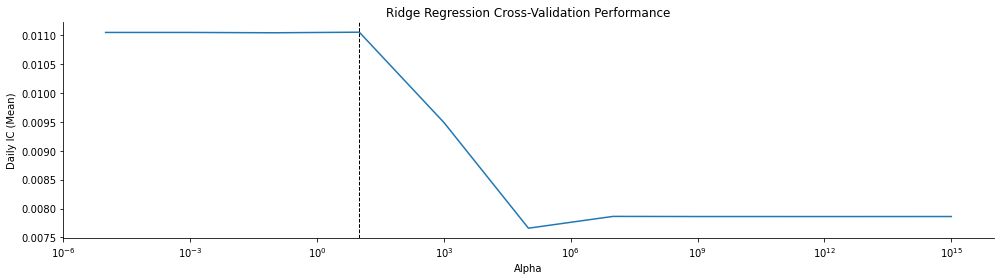

In [48]:
ax = pd.Series(ic_by_day_ridge).plot(figsize=(14, 4),
                                     logx=True,
                                     title='Ridge Regression Cross-Validation Performance')
ax.axvline(best_alpha_ridge, c='k', ls='--', lw=1)
ax.set_ylabel('Daily IC (Mean)')
ax.set_xlabel('Alpha')
sns.despine()
plt.tight_layout();

#### Persist results

In [49]:
ridge_preds[best_alpha_ridge].to_hdf('predictions.h5', key='ridge_regression', mode='a')

### Lasso Regression

In [50]:
lasso_alphas = np.logspace(-15, -5, 11)
lasso_alphas

array([1.e-15, 1.e-14, 1.e-13, 1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08,
       1.e-07, 1.e-06, 1.e-05])

In [51]:
from sklearn.linear_model import Lasso

In [52]:
%%time

lasso_preds = []
scaler = MinMaxScaler()
for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
    print(f'\nFold {i}')
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    X_train = scaler.fit_transform(X_train)
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    X_test = scaler.transform(X_test)    
    cv_predictions = []
    for alpha in lasso_alphas:
        print(f'{alpha:.0e}', end=' ', flush=True)
        lasso = Lasso(alpha=alpha)
        lasso.fit(X_train, y_train)
        y_pred = lasso.predict(X_test)
        cv_predictions.append(pd.DataFrame({alpha: y_pred},
                                           index=y_test.index))
    lasso_preds.append(pd.concat(cv_predictions, axis=1).assign(y_test=y_test))

lasso_preds = pd.concat(lasso_preds)


Fold 0
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 1
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 2
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 3
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 4
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 5
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 6
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 7
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 8
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 9
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 10
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 11
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 12
1e-15 1e-14 1e-13 1e-12 1e-11 1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 
Fold 13
1e-15 1e-14 1e-13 1e-12 1e

#### Evaluate Predictions

In [53]:
ic_by_day_lasso = {}
for alpha in lasso_alphas:
    ic_by_day_lasso[alpha] = (lasso_preds.groupby(level='date')
                              .apply(lambda x: spearmanr(x[alpha], x.y_test)[0]).mean())

In [54]:
pd.Series(ic_by_day_lasso)

1.000000e-15    0.011053
1.000000e-14    0.011053
1.000000e-13    0.011053
1.000000e-12    0.011053
1.000000e-11    0.011052
1.000000e-10    0.011052
1.000000e-09    0.011054
1.000000e-08    0.011052
1.000000e-07    0.011086
1.000000e-06    0.011744
1.000000e-05    0.009853
dtype: float64

In [55]:
best_alpha_lasso = pd.Series(ic_by_day_lasso).idxmax()
best_alpha_lasso

1e-06

In [58]:
best_ic_by_day_lasso = (lasso_preds.groupby(level='date')
                        .apply(lambda x: spearmanr(x[best_alpha_lasso], x.y_test)[0]))

best_ic_by_day_lasso.describe().iloc[1:]

mean    0.011744
std     0.162174
min    -0.510554
25%    -0.080682
50%     0.015257
75%     0.107025
max     0.590755
dtype: float64

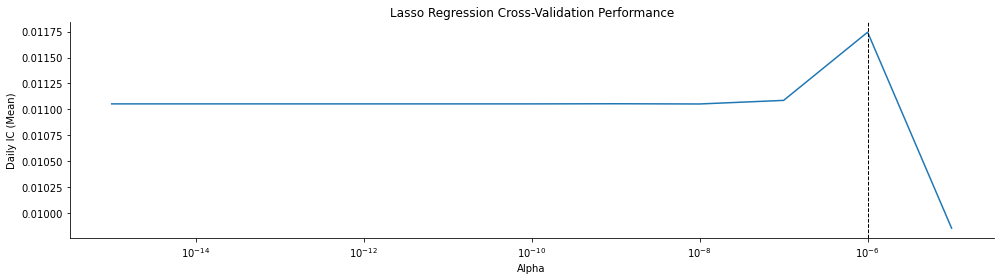

In [56]:
ax = pd.Series(ic_by_day_lasso).plot(figsize=(14, 4),
                                     logx=True,
                                     title='Lasso Regression Cross-Validation Performance')
ax.axvline(best_alpha_lasso, c='k', ls='--', lw=1)
ax.set_ylabel('Daily IC (Mean)')
ax.set_xlabel('Alpha')
sns.despine()
plt.tight_layout();

#### Persist results

In [57]:
lasso_preds[best_alpha_lasso].to_hdf('predictions.h5', key='lasso_regression', mode='a')